In [90]:
# import lib
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Embedding,
    Concatenate, Dropout, Flatten
)
from tensorflow.keras.models import Model


import matplotlib.pyplot as plt


In [91]:
df = pd.read_csv('D:/project_data_mining/src/dataset.csv')

In [92]:
# encode category 
cat2id = {c: i for i, c in enumerate(df["Expenditure_category"].unique())}
df["cat_id"] = df["Expenditure_category"].map(cat2id)
N_CAT = len(cat2id)

In [ ]:
# # split train/val/test 
train_df = df[(df["TIME_PERIOD"] >= "2011-01-01") & (df["TIME_PERIOD"] <= "2020-12-31")]
val_df   = df[(df["TIME_PERIOD"] >= "2021-01-01") & (df["TIME_PERIOD"] <= "2022-12-31")]
test_df  = df[(df["TIME_PERIOD"] >= "2023-01-01") & (df["TIME_PERIOD"] <= "2025-12-31")]


In [94]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_df[["CPI", "Energy", "GDP"]])

def scale(df):
    df = df.copy()
    df[["CPI", "Energy", "GDP"]] = scaler.transform(
        df[["CPI", "Energy", "GDP"]]
    )
    return df

train_df = scale(train_df)
val_df   = scale(val_df)
test_df  = scale(test_df)


In [95]:
# create sequence

def make_sequence(df, window=12):
    X_seq, y, cat, time_idx = [], [], [], []

    for cid, g in df.groupby("cat_id"):
        g = g.sort_values("TIME_PERIOD")
        values = g[["CPI", "Energy", "GDP"]].values

        for i in range(window, len(g)):
            X_seq.append(values[i-window:i])
            y.append(values[i, 0])   # CPI(t)
            cat.append(cid)
            time_idx.append(g["TIME_PERIOD"].iloc[i])

    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y, dtype=np.float32),
        np.array(cat, dtype=np.int32),
        np.array(time_idx)
    )


In [96]:
WINDOW = 12

X_train, y_train, cat_train, t_train = make_sequence(train_df, WINDOW)
X_val,   y_val,   cat_val,   t_val   = make_sequence(val_df, WINDOW)
X_test,  y_test,  cat_test,  t_test  = make_sequence(test_df, WINDOW)


In [97]:
# model LSTM
seq_in = Input(shape=(WINDOW, 3), name="seq")
cat_in = Input(shape=(1,), name="cat")

cat_emb = Embedding(N_CAT, 8)(cat_in)
cat_emb = Flatten()(cat_emb)
cat_emb = Dense(8, activation="relu")(cat_emb)

x = LSTM(64)(seq_in)
x = Concatenate()([x, cat_emb])
x = Dense(32, activation="relu")(x)
out = Dense(1)(x)

model = Model([seq_in, cat_in], out)
model.compile(optimizer="adam", loss="mse")

model.summary()



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 1, 8)      │         96 │ cat[0][0]         │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq (InputLayer)    │ (None, 12, 3)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 8)         │          0 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 64)        │     17,408 │ seq[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 8)         │         72 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 72)        │          0 │ lstm_8[0][0],     │
│ (Concatenate)       │                   │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      2,336 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │         33 │ dense_21[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,945 (77.91 KB)

 Trainable params: 19,945 (77.91 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# train
model.fit(
    [X_train, cat_train],
    y_train,
    validation_data=([X_val, cat_val], y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)



Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.1741 - val_loss: 0.0380
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0146 - val_loss: 0.0445
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0100 - val_loss: 0.0396
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0092 - val_loss: 0.0608
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0087 - val_loss: 0.0670
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0085 - val_loss: 0.0437
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0085 - val_loss: 0.0434
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0083 - val_loss: 0.0729
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0084 - val_loss: 0.0604
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0077 - val_loss: 0.0427
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0076 - val_loss: 0.0521
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

In [99]:
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)
print("cat_test shape :", cat_test.shape)


X_test shape : (264, 12, 3)
y_test shape : (264,)
cat_test shape : (264,)


In [100]:
y_pred = model.predict([X_test, cat_test]).flatten()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [ ]:
# metric
def smape(y_true, y_pred):
    return np.mean(
        2 * np.abs(y_pred - y_true) /
        (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    ) * 100

def pred_10(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / np.abs(y_true) < 0.10)

# eval
def evaluate_global(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    smp  = smape(y_true, y_pred)
    p10  = pred_10(y_true, y_pred)

def evaluate(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    smp  = smape(y_true, y_pred)
    p10  = pred_10(y_true, y_pred)

    # print ra màn hình
    print(f"\n{name} (LSTM MODEL)")
    print(f"RMSE       : {rmse:.4f}")
    print(f"MAE        : {mae:.4f}")
    print(f"sMAPE (%)  : {smp:.2f}")
    print(f"Pred(<10%) : {p10:.2f}")

evaluate(y_test, y_pred, name="")


 (LSTM MODEL)
RMSE       : 0.2652
MAE        : 0.2410
sMAPE (%)  : 18.61
Pred(<10%) : 0.14


In [102]:
# inverse
def inverse_cpi(x):
    return x * scaler.scale_[0] + scaler.mean_[0]

y_test_inv = inverse_cpi(y_test)
y_pred_inv = inverse_cpi(y_pred)



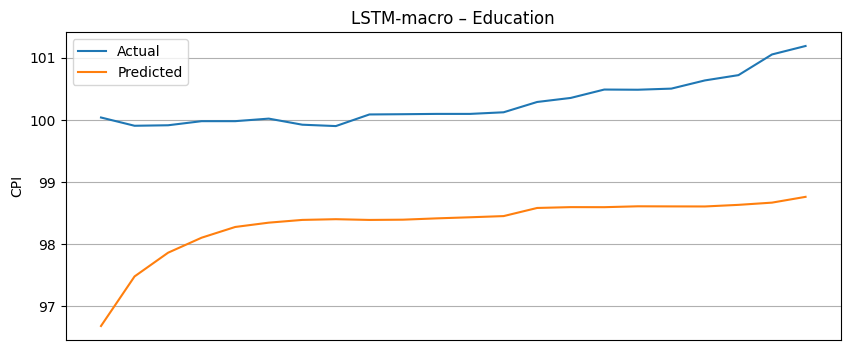

In [112]:
# viz
import matplotlib.pyplot as plt

cat_name = "Education"
cid = cat2id[cat_name]
mask = (cat_test == cid)

plt.figure(figsize=(10,4))
plt.plot(t_test[mask], y_test_inv[mask], label="Actual")
plt.plot(t_test[mask], y_pred_inv[mask], label="Predicted")
plt.title(f"LSTM-macro – {cat_name}")
plt.ylabel("CPI")
plt.xticks([])
plt.legend()
plt.grid(True)
plt.show()